# Executive Summary

*Problem:*

Order data from 100 sneaker shops was analyzed to investigate to unusually high average order value (AOV) of $3145.13.

*Analysis:*

The following anomalies were detected in the data:


1.   Shop 42:

      *   User 607 consistently purchases 2,000 pairs of sneakers at 4:00 on 17 separate occasions.
      *   The suspiciously consistent pattern of these large transactions warrants further investigation.
      *   Without further context or detail, it is difficult to determine the legitimacy of these orders.
      *   It is recommended to exclude these orders from the analysis.


2.   Shop 78:
      
      *   The unit price of sneakers at this store is $25,725.
      *   Given the unreasonable high cost of sneakers at this store, it is recommended that orders from this store are excluded from the analysis.

*New Metric:*

Average unit retail (AUR) is suggested to be used as the new metric.
AUR can be calculated as:

  AUR = Total revenue [$] / Total items sold

This metric is less sensitive to extremely large statistical outliers in the dataset, because it accounts for the total number of items ordered. Orders with a large number of items will not affect AUR, but will skew the original AOV metric.

After removing the anomalies detected in the *Analysis*, the calculated AUR is **$151.69**.

*Re-Calculated AOV:*

AOV can still be used as a metric to evaluate the data set, if the detected anomalies are excluded from the calculation. 
Excluding the anomalies detected in the *Analysis*, the calculated AOV is **$302.58**.







# Set Up



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
from scipy import stats
from collections import Counter, OrderedDict

# supress warnings
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import Data

In [ ]:
# https://towardsdatascience.com/read-data-from-google-sheets-into-pandas-without-the-google-sheets-api-5c468536550
sheet_id = '16i38oonuX1y1g7C_UAmiK9GkY7cS-64DfiDMNiR41LM'
sheet_name = 'Sheet1'
data_url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'

In [ ]:
df = pd.read_csv(data_url)
df.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


# Explore Data

In [ ]:
def extract_dates(df, col):
  '''
  Extract the date portion from the "created_at" field.
  '''
  date_strings = list(df[col].values)
  dates_list = [d.split(' ')[0] for d in date_strings]
  return dates_list

def format_dates(date_list):
  '''
  Convert the date portion of the "created_at" field
  to 
  '''
  formatted_date_list = [datetime.strptime(date_string, '%Y-%m-%d') \
                         for date_string in date_list]
  return formatted_date_list

In [ ]:
dates = extract_dates(df, 'created_at')
formatted_dates = format_dates(dates)

df['date'] = dates
df['per_item_revenue'] = df['order_amount'] / df['total_items']

In [ ]:
df.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,date,per_item_revenue
0,1,53,746,224,2,cash,2017-03-13 12:36:56,2017-03-13,112.0
1,2,92,925,90,1,cash,2017-03-03 17:38:52,2017-03-03,90.0
2,3,44,861,144,1,cash,2017-03-14 4:23:56,2017-03-14,144.0
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37,2017-03-26,156.0
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11,2017-03-01,156.0


In [ ]:
print(f'Numer of data points: {len(df)}')

Numer of data points: 5000


In [ ]:
print(f'Data ranges from {min(df.date.values)} to {max(df.date.values)}')

Data ranges from 2017-03-01 to 2017-03-30


## Confirm Naive AOV Calculation

In [ ]:
def aov_calc(total_revenue, num_orders):
  '''
  Calculate AOV.
  '''
  aov = round(total_revenue / num_orders, 2)
  return aov

In [ ]:
# confirm naive AOV calculation
total_revenue = sum(df.order_amount)
num_orders = len(df)
naive_aov = aov_calc(total_revenue, num_orders)
print(f'Naive AOV: ${naive_aov}')

Naive AOV: $3145.13


## Find Outliers

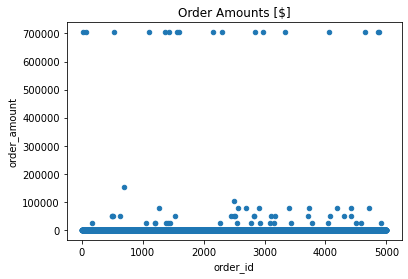

In [ ]:
# explore distribution of order amounts
df.plot.scatter(x='order_id', y='order_amount')
plt.title('Order Amounts [$]');

In [ ]:
def get_zscores(array):
  '''Calculate absolute z-scores of a sample of data.'''
  z_scores = stats.zscore(array)
  # abs_z_scores = np.abs(z_scores)
  return z_scores

def check_outlier(z_score):
  '''Check if a z-score is greater than 3'''
  if abs(z_score) > 3:
    return True
  else:
    return False

In [ ]:
# calculate z-score of order amounts
df['z_scores'] = get_zscores(df.order_amount)
df['outlier'] = df['z_scores'].apply(check_outlier)

In [ ]:
# split dataframe into inliers / outliers based on z-score of order amounts
inlier_df = df[df.outlier == False]
outlier_df = df[df.outlier == True]
outlier_df.head(10)

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,date,per_item_revenue,z_scores,outlier
15,16,42,607,704000,2000,credit_card,2017-03-07 4:00:00,2017-03-07,352.0,16.978727,True
60,61,42,607,704000,2000,credit_card,2017-03-04 4:00:00,2017-03-04,352.0,16.978727,True
520,521,42,607,704000,2000,credit_card,2017-03-02 4:00:00,2017-03-02,352.0,16.978727,True
691,692,78,878,154350,6,debit,2017-03-27 22:51:43,2017-03-27,25725.0,3.663050,True
1104,1105,42,607,704000,2000,credit_card,2017-03-24 4:00:00,2017-03-24,352.0,16.978727,True
1362,1363,42,607,704000,2000,credit_card,2017-03-15 4:00:00,2017-03-15,352.0,16.978727,True
1436,1437,42,607,704000,2000,credit_card,2017-03-11 4:00:00,2017-03-11,352.0,16.978727,True
1562,1563,42,607,704000,2000,credit_card,2017-03-19 4:00:00,2017-03-19,352.0,16.978727,True
1602,1603,42,607,704000,2000,credit_card,2017-03-17 4:00:00,2017-03-17,352.0,16.978727,True
2153,2154,42,607,704000,2000,credit_card,2017-03-12 4:00:00,2017-03-12,352.0,16.978727,True


In [ ]:
print(f'Number of outliers with z-score >3:  {len(outlier_df)}')

Number of outliers with z-score >3:  18


In [ ]:
# AOV for outliers with z-score > 3
outlier_aov = aov_calc(outlier_df.order_amount.sum(), len(outlier_df))
print(f'AOV for outliers (z-score > 3): ${outlier_aov}')

AOV for outliers (z-score > 3): $673463.89


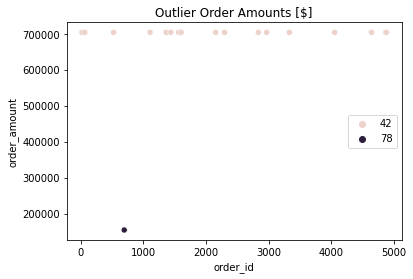

In [ ]:
# visualize outliers by shop ID
sns.scatterplot(x='order_id', y='order_amount', data=outlier_df, hue='shop_id')
plt.legend(loc='center right');
plt.title('Outlier Order Amounts [$]');

Outliers (z-score > 3) come from only 2 stores (Shops 42, 78). Further investigation is required.

### Explore Data for Shops 42 & 78

#### Shop 42

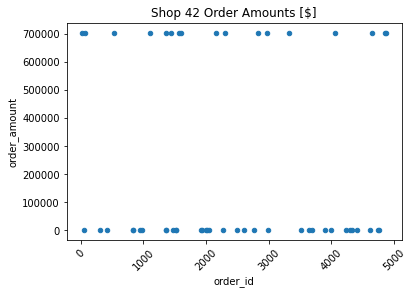

In [ ]:
# visualize all orders for Shop 42
df[df.shop_id == 42].plot.scatter(x='order_id', y='order_amount')
plt.xticks(rotation=45);
plt.title('Shop 42 Order Amounts [$]');

In [ ]:
# find unique order amounts for  all orders for Shop 42
shop42_df = df.query('shop_id == 42')
shop42_amounts = sorted(shop42_df.order_amount.unique(), reverse=True)
print(f'Unique order amounts [$] for Shop 42:\n{shop42_amounts}')

Unique order amounts [$] for Shop 42:
[704000, 1760, 1408, 1056, 704, 352]


In [ ]:
def tally_order_amounts(order_amounts):
  '''
  Count the number of occurences of each order amount.
  '''
  counts = Counter(order_amounts)
  counts_dict = dict(OrderedDict(counts))
  sorted_dict = dict(sorted(counts_dict.items()))
  return sorted_dict

In [ ]:
# tally count of order amounts for Shop 42
shop42_counts = tally_order_amounts(shop42_df.order_amount)
shop42_counts

{352: 15, 704: 13, 1056: 3, 1408: 2, 1760: 1, 704000: 17}

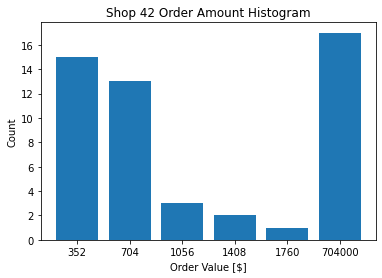

In [ ]:
# plot order amounts histogram for Shop 42
plt.bar(range(len(shop42_counts)), list(shop42_counts.values()), align='center');
plt.xticks(range(len(shop42_counts)), list(shop42_counts.keys()));
plt.xlabel('Order Value [$]')
plt.ylabel('Count');
plt.title('Shop 42 Order Amount Histogram');

Text(0.5, 1.0, 'Shop 42 - Unit Price per Order')

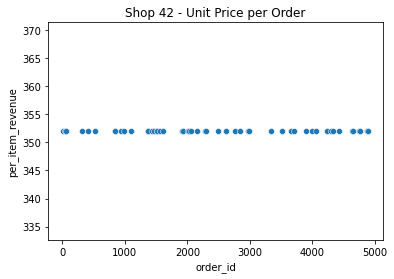

In [ ]:
# visualize per item revenue for Shop 42
sns.scatterplot(x='order_id', y='per_item_revenue', data=shop42_df)
plt.title('Shop 42 - Unit Price per Order');

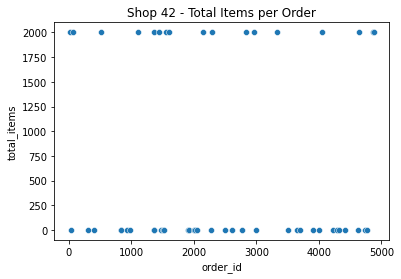

In [ ]:
# visualize number of items sold for Shop 42
sns.scatterplot(x='order_id', y='total_items', data=shop42_df)
plt.title('Shop 42 - Total Items per Order');

In [ ]:
shop42_df.total_items.unique()

array([2000,    1,    2,    3,    5,    4])

In [ ]:
shop42_df.query('order_amount == 704000').sort_values('date').head(10)

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,date,per_item_revenue,z_scores,outlier
520,521,42,607,704000,2000,credit_card,2017-03-02 4:00:00,2017-03-02,352.0,16.978727,True
4646,4647,42,607,704000,2000,credit_card,2017-03-02 4:00:00,2017-03-02,352.0,16.978727,True
60,61,42,607,704000,2000,credit_card,2017-03-04 4:00:00,2017-03-04,352.0,16.978727,True
15,16,42,607,704000,2000,credit_card,2017-03-07 4:00:00,2017-03-07,352.0,16.978727,True
2297,2298,42,607,704000,2000,credit_card,2017-03-07 4:00:00,2017-03-07,352.0,16.978727,True
1436,1437,42,607,704000,2000,credit_card,2017-03-11 4:00:00,2017-03-11,352.0,16.978727,True
2153,2154,42,607,704000,2000,credit_card,2017-03-12 4:00:00,2017-03-12,352.0,16.978727,True
1362,1363,42,607,704000,2000,credit_card,2017-03-15 4:00:00,2017-03-15,352.0,16.978727,True
1602,1603,42,607,704000,2000,credit_card,2017-03-17 4:00:00,2017-03-17,352.0,16.978727,True
1562,1563,42,607,704000,2000,credit_card,2017-03-19 4:00:00,2017-03-19,352.0,16.978727,True


Shop 42 logs regular orders from User 607. The orders are always at 4:00, and are always for a large (2,000) amount of sneakers. This large order amount is skewing the naive AOV calculation.

#### Shop 78

In [ ]:
# find unique order amounts for  all orders for Shop 78
shop78_df = df.query('shop_id == 78')
shop78_amounts = sorted(shop78_df.order_amount.unique(), reverse=True)
print(f'Unique order amounts [$] for Shop 78:\n{shop78_amounts}')

Unique order amounts [$] for Shop 78:
[154350, 102900, 77175, 51450, 25725]


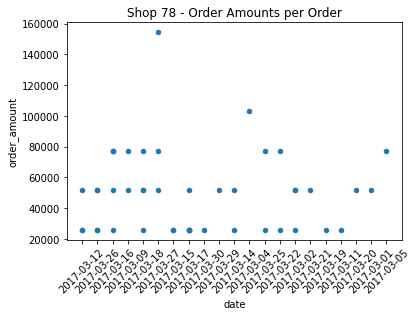

In [ ]:
# visualize all orders for Shop 78
df[df.shop_id == 78].plot.scatter(x='date', y='order_amount')
plt.xticks(rotation=45);
plt.title('Shop 78 - Order Amounts per Order');

In [ ]:
# tally count of order amounts for Shop 78
shop78_counts = tally_order_amounts(shop78_df.order_amount)
shop78_counts

{25725: 19, 51450: 16, 77175: 9, 102900: 1, 154350: 1}

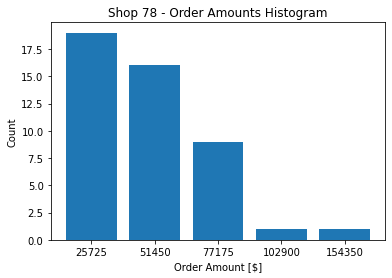

In [ ]:
# plot order amounts histogram for Shop 78
plt.bar(range(len(shop78_counts)), list(shop78_counts.values()), align='center');
plt.xticks(range(len(shop78_counts)), list(shop78_counts.keys()));
plt.xlabel('Order Amount [$]');
plt.ylabel('Count');
plt.title('Shop 78 - Order Amounts Histogram');

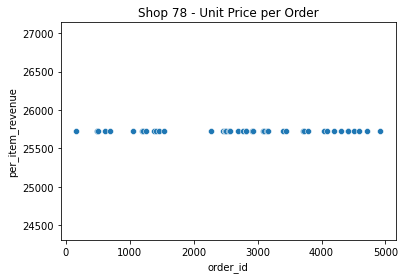

In [ ]:
# visualize per item revenue for Shop 78
sns.scatterplot(x='order_id', y='per_item_revenue', data=shop78_df)
plt.title('Shop 78 - Unit Price per Order');

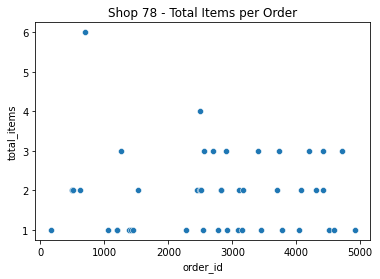

In [ ]:
# visualize number of items sold for Shop 78
sns.scatterplot(x='order_id', y='total_items', data=shop78_df)
plt.title('Shop 78 - Total Items per Order');

In [ ]:
shop78_df.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,date,per_item_revenue,z_scores,outlier
160,161,78,990,25725,1,credit_card,2017-03-12 5:56:57,2017-03-12,25725.0,0.547014,False
490,491,78,936,51450,2,debit,2017-03-26 17:08:19,2017-03-26,25725.0,1.170221,False
493,494,78,983,51450,2,cash,2017-03-16 21:39:35,2017-03-16,25725.0,1.170221,False
511,512,78,967,51450,2,cash,2017-03-09 7:23:14,2017-03-09,25725.0,1.170221,False
617,618,78,760,51450,2,cash,2017-03-18 11:18:42,2017-03-18,25725.0,1.170221,False


The unit price of sneakers at Shop 78 is extremely high.

## Per Item Revenue

In [ ]:
# calculate maximum unit price per shop
price_df = df[['shop_id', 'per_item_revenue']].groupby(by=['shop_id']).max()
price_df = price_df.sort_values(by='per_item_revenue', ascending=False)
price_df.head()

,per_item_revenue
shop_id,
78,25725.0
42,352.0
12,201.0
89,196.0
99,195.0


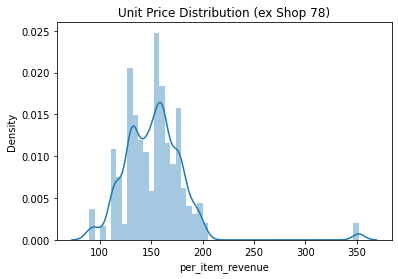

In [ ]:
# visualize distribution of unit prices (excluding Shop 78)
sns.distplot(df.query('shop_id != 78').per_item_revenue)
plt.title('Unit Price Distribution (ex Shop 78)');

All other stores have a much more reasonable unit price for their sneakers when compared to Shop 78. This is further evidence that the data from Shop 78 is erroneous.

# New Metric



*   Cannot use AOV as a metric because of suspiciously large order amounts from Shop 42 & 78.
*   Cannot use total units sold as a metric because of suspiciously large order volumes from Shop 42.




In [ ]:
# filter data to exclude outliers
filtered_df = df.query('shop_id != 78 and order_amount < 700000')
filtered_df.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,date,per_item_revenue,z_scores,outlier
0,1,53,746,224,2,cash,2017-03-13 12:36:56,2017-03-13,112.0,-0.070766,False
1,2,92,925,90,1,cash,2017-03-03 17:38:52,2017-03-03,90.0,-0.074013,False
2,3,44,861,144,1,cash,2017-03-14 4:23:56,2017-03-14,144.0,-0.072705,False
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37,2017-03-26,156.0,-0.072414,False
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11,2017-03-01,156.0,-0.072414,False


In [ ]:
# calculate revenue, total number of orders, and total items for filtered dataset
filtered_revenue = filtered_df.order_amount.sum()
filtered_num_orders = len(filtered_df)
filtered_total_items = filtered_df.total_items.sum()

In [ ]:
filtered_aov = aov_calc(filtered_revenue, filtered_num_orders)
print(f'AOV for filtered dataset: ${filtered_aov}')

AOV for filtered dataset: $302.58


In [97]:
avg_unit_cost = filtered_revenue / filtered_total_items
print(f'Average Unit Retail (AUR) for filtered dataset: ${round(avg_unit_cost, 2)}')

Average Unit Retail (AUR) for filtered dataset: $151.69


In [96]:
# calculate original AUR of dataset
print(f'AUR for original dataset: ${round(df.order_amount.sum() / df.total_items.sum(), 2)}')

AUR for original dataset: $357.92
